In [1]:
import geopandas as gpd
import geopy
import shapely as sh
from shapely.geometry import Point

In [2]:
def coordToArray(geopdcoord):
    coord = str(geopdcoord['geometry'][0])
    j = coord.replace("POINT (","") #remove palavra POINT (
    i = j.replace(")","").split(" ") # remove ultimo parenteses e splita o que sobrou resultando num array com as 2 coord
    ponto = Point(float(i[0]),float(i[1]))
    return ponto

In [49]:
#oor = gpd.tools.geocode("Avenida Pedro Quaresma da Silva , Novo Hamburgo", timeout=5, provider='here', app_id='SEU APP ID HERE', app_code='SEU CODE ID HERE')
coor = gpd.tools.geocode("Avenida Pedro Quaresma da Silva 980, Novo Hamburgo", timeout=5)

#rua = gpd.tools.reverse_geocode([Point(-51.12429,-30.09012)], timeout=5,provider='here', app_id='SEU APP ID HERE', app_code='SEU CODE ID HERE')
#print(coor.geometry)
#rua

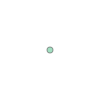

In [37]:
latlong = coordToArray(coor)
latlong

In [47]:
coor['geometry']

0    POINT (-51.17034 -29.67806)
Name: geometry, dtype: geometry

In [3]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_excel("RouboRecupVec2.xlsx")

In [12]:
#df.head(5)

In [4]:
idhere='SEU ID DA HERE'
codehere='SEU CODIGO DA HERE'

In [21]:
#seleciona apenas linhas que tem nome de rua diferente de vazio ou -  e de um ano específico
mask = (pd.isna(df['Geocode']) & pd.notna(df['Nome Rua']) & (df['Ano']>=2014)&(df['Ano']<=2019))#máscara para selecionar apenas dados sem geo code e com rua 
dfSgeo = df.loc[mask]

In [22]:
dfSgeo.shape

(86227, 18)

In [23]:
mask = (((dfSgeo['Município']=='Porto Alegre')|
         (dfSgeo['Município']=='Canoas')|
         (dfSgeo['Município']=='Viamão')| 
         (dfSgeo['Município']=='Cachoeirinha')|
         (dfSgeo['Município']=='Gravataí')|
         (dfSgeo['Município']=='São Leopoldo')|
         (dfSgeo['Município']=='Novo Hamburgo')|
         (dfSgeo['Município']=='Alvorada')|
         (dfSgeo['Município']=='Sapucaia do Sul')|
         (dfSgeo['Município']=='Guaíba')|
         (dfSgeo['Município']=='Eldorado do Sul')|
         (dfSgeo['Município']=='Esteio')) & pd.notna(dfSgeo['Nro']))

dfteste = dfSgeo.loc[mask]
dfteste.shape

(39072, 18)

In [24]:
newgeocode = []

In [25]:
#LAÇO DE REPETIÇÃO QUE PEGA COLUNAS DE RUA, NRO E CIDADE E CONSULTA NO HERE WEGO MAPS
import time
i=0
for i in range(len(dfteste.index)):
#for i in range(5):    
    time.sleep(0.4) #tempo pro programa pensar
    endereco = str(dfteste.iat[i,14])+' '+str(dfteste.iat[i,15])+', '+str(dfteste.iat[i,12]) #colunas de rua, nro e cidade
    #print(endereco)
    
    tentativas = [3,5,7,10,15]    
    for tmout in tentativas: #laço para tentar pesquisar com timouts diferentes
        try:
            coordenadas=gpd.tools.geocode(endereco, timeout=tmout,provider='here', app_id=idhere, app_code=codehere)
            newgeocode.append(coordToArray(coordenadas))
            #print(tmout)
            break # se der certo ele quebra o for
        except:
            if tmout == 15: #se chegou até o time out 15 e entrou na exceção então insere coordenada do guaíba
                coordenadas = Point(-51.278229,-30.068491) #coordenadas no meio do lago Guaíba
                newgeocode.append(coordenadas)
                break
            else:
                continue #se ainda não chegou no tentou o time out 15 então continua tentando      

In [26]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

now = 2019-11-11 23:15:42.363031


In [27]:
len(newgeocode)

39072

In [28]:
dfNgeo = pd.DataFrame({'Geocode Novo':newgeocode})
dfteste.index = range(len(dfteste)) #reseta os index do conjunto que foi pesquisado para possibilitar o concat
dfFinal = pd.concat([dfteste,dfNgeo], axis=1, sort=False) #une o Df de pesquisa com o df de coordendas obtidas
#dfFinal.head()
#dfFinal['New Geocode'] = newgeocode

In [111]:
#Cria tabela
#with pd.ExcelWriter('Georreferenciado2005.xlsx') as writer:
#    dfFinal.to_excel(writer, sheet_name='Teste')    

In [29]:
#Adiciona mais uma aba a um arquivo existente
with pd.ExcelWriter('Georreferenciado2005.xlsx', mode='a', engine='openpyxl') as writer: 
    dfFinal.to_excel(writer, sheet_name='20142019') 